In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import calendar
from sklearn.decomposition import PCA as PCA
from sklearn.linear_model import LinearRegression
from numba import jit
from HMM_Cal import execute
%matplotlib inline


/Users/liyuefan/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
data=pd.read_csv('/Users/liyuefan/Documents/gtja/GSCI_ER_Indices.csv',header=None)

In [3]:
index_list=data.iloc[0,:].dropna()
index_list=map(lambda x: x.split(' ')[0],index_list)

In [4]:


ER_dict={'SPGCCCP':'Cocoa','SPGCCNP':'Corn','SPGCCTP':'Cotton','SPGCKCP':'Coffee',
        'SPGCSBP':'Sugar','SPGCKWP':'Kansas wheat','SPGCWHP':'Wheat',
         'SPGCSOP':'Soybeans','SPGCLCP':'Live cattle','SPGCLHP':'Lean hogs','SPGCFCP':'Feeder cattle',
        'SPGCIAP':'Aluminium','SPGCICP':'Copper','SPGCIKP':'Nickel','SPGCILP':'Lead','SPGCIZP':'Zinc',
        'SPGCBRP':'Brent','SPGCCLP':'Crude oil','SPGCGOP':'Gasoil','SPGCHOP':'Heating oil',
        'SPGCHUP':'Gasoline','SPGCNGP':'Natural Gas','SPGCGCP':'Gold','SPGCSIP':'Silver'}

def name_kind(x):
    return ER_dict[x]

In [5]:
def plot_loading(r_all):
    for i in range(r_all.shape[1]):
        plt.figure(figsize=(3,9))
        plt.subplot(r_all.shape[1],1,i+1)
        
        temp=r_all[[r_all.columns[i]]].sort(r_all.columns[i])
        xticks=np.arange(len(temp))
        xlabels=list(temp.index)
        plt.barh(xticks,temp[r_all.columns[i]],align='center',color='yellow',alpha=0.8)
        plt.title('loadings of PC%s'%(i+1))
        plt.yticks(xticks,xlabels,size='medium',rotation=0);
        plt.autoscale()

In [6]:
data_for_PCA=pd.DataFrame()
for i in range(data.shape[1]):
    if i%3==1:
        temp=data.iloc[2:,[i-1,i]]
        temp=temp.rename(columns={i-1:'update_date',i:'%s'%index_list[i/3]})
        temp['update_date']=pd.to_datetime(temp['update_date'])
        temp.index=[temp['update_date']]
        temp[index_list[i/3]]=temp[index_list[i/3]].apply(float)
        temp=temp.drop(['update_date'],axis=1)
        data_for_PCA=pd.concat([data_for_PCA,temp],axis=1,join='inner')
    else:
        pass

y=data_for_PCA['SPGSCI'].apply(float)
ind_var=data_for_PCA.copy()
ind_var_diff=pd.DataFrame()
for col in ind_var.columns:
    ind_var[col]=ind_var[col].apply(float)
    ind_var_diff[col]=np.diff(np.log(ind_var[col]))
ind_var_diff['update_date']=ind_var.index[1:]
ind_var_diff.index=[ind_var_diff['update_date']]
y=ind_var_diff[['SPGSCI']]
ind_var_diff.drop(['update_date','SPGSCI'],axis=1,inplace=True)



In [7]:
def position(data_for_PCA):
    data_for_PCA['ma10']=pd.rolling_mean(data_for_PCA['SPGSCI'],10)
    data_for_PCA['ma20']=pd.rolling_mean(data_for_PCA['SPGSCI'],20)
    data_for_PCA['ma60']=pd.rolling_mean(data_for_PCA['SPGSCI'],60)
    data_for_PCA['ma100']=pd.rolling_mean(data_for_PCA['SPGSCI'],100)
    data_for_PCA['ma200']=pd.rolling_mean(data_for_PCA['SPGSCI'],200)

    data_for_PCA['ma_diff_1']=data_for_PCA['SPGSCI']-data_for_PCA['ma10']
    data_for_PCA['ma_diff_2']=data_for_PCA['SPGSCI']-data_for_PCA['ma20']
    data_for_PCA['ma_diff_3']=data_for_PCA['SPGSCI']-data_for_PCA['ma60']
    data_for_PCA['ma_diff_4']=data_for_PCA['SPGSCI']-data_for_PCA['ma100']
    data_for_PCA['ma_diff_5']=data_for_PCA['SPGSCI']-data_for_PCA['ma200']
    
    def fx(x):
        if x>0:
            return 0.2
        elif x<0:
            return -0.2
        else:
            return 0
    data_for_PCA['s_1']=data_for_PCA['ma_diff_1'].apply(fx)
    data_for_PCA['s_2']=data_for_PCA['ma_diff_2'].apply(fx)
    data_for_PCA['s_3']=data_for_PCA['ma_diff_3'].apply(fx)
    data_for_PCA['s_4']=data_for_PCA['ma_diff_4'].apply(fx)
    data_for_PCA['s_5']=data_for_PCA['ma_diff_5'].apply(fx)
    data_for_PCA['position']=data_for_PCA['s_1']+data_for_PCA['s_2']\
                                +data_for_PCA['s_3']+data_for_PCA['s_4']+data_for_PCA['s_5']
    return data_for_PCA

In [8]:
data_for_PCA['ma30']=pd.rolling_mean(data_for_PCA['SPGSCI'],30)
data_for_PCA['ma60']=pd.rolling_mean(data_for_PCA['SPGSCI'],60)
data_for_PCA['position']=data_for_PCA['ma30']-data_for_PCA['ma60']
data_for_PCA['position']=data_for_PCA['position'].apply(lambda x:1 if x>0 else -1)

In [9]:
# data_for_PCA=position(data_for_PCA)
ma_diff=[np.nan]
ma_diff.extend(list(data_for_PCA['position'])[:-1])
data_for_PCA['position']=ma_diff

In [10]:

def pca_weight(ind_var_diff):
    X=ind_var_diff.as_matrix()

    pca=PCA(n_components=10,whiten=True)

    pca.fit(X)

    X=pca.transform(X)

    r=pd.DataFrame(pca.components_[0])
    r['name']=map(name_kind,ind_var_diff.columns)
    r.index=[r['name']]

    r.drop('name',axis=1,inplace=True)
    

    ##定义一个函数用来画各个主成分的构成loading


    # plot_loading(r)

    # 计算loading
    eigenvalues=pca.explained_variance_ratio_
    sqrt_eigen=np.sqrt(pca.explained_variance_ratio_)
#     loadings=pd.DataFrame()
#     for i in range(len(sqrt_eigen)):
#         loadings['PC%s'%(i+1)]=r[i]**2
    
#     loadings['all_weights']=loadings.sum(axis=1)
    weights=r[0]
    


    weights=weights/sum(weights)
    return list(weights),eigenvalues[0]


In [11]:

##输入的参数all_data需要时间戳格式的索引(index)列
def loop_pca(all_data):
    total=[]
    pca_all=[]
    date_start=pd.to_datetime(min(all_data.index))
    date_start=date_start+np.timedelta64(6,'M')
    date_end=pd.to_datetime(max(all_data.index))
    for day in pd.date_range(date_start,date_end):
#         if calendar.weekday(day.year,day.month,day.day)==1:

        date_f=day-np.timedelta64(6,'M')
        date_t=day
        date_t=date_t-np.timedelta64(1,'D')

        ind_var_diff=all_data[date_f:date_t]

        w,pca=pca_weight(ind_var_diff)
        pca_all.append([pca,day])

        if day.month in [1,4,7,10] and day.day==1:

            
            w.append(day)
            total.append(w)  
        else:
            w=[np.nan for x in np.arange(all_data.shape[1])]
            w.append(day)
#             pca_all.append([np.nan,day])
            total.append(w)
    col_list=list(all_data.columns)
    col_list.append('update_date')
    all_w=pd.DataFrame(total,columns=col_list)
    all_w['update_date']=pd.to_datetime(all_w['update_date'])
    all_w=all_w.fillna(method='ffill')
    all_w=all_w.dropna(axis=0)
    pca_all=pd.DataFrame(pca_all,columns=['dir_strength','update_date'])
    pca_all['update_date']=pd.to_datetime(pca_all['update_date'])
    pca_all['update_date']=pca_all['update_date'].apply(lambda x: x.date())
    pca_all.index=[pca_all['update_date']]
    pca_all.drop(['update_date'],axis=1,inplace=True)
    return all_w,pca_all

In [12]:
st=datetime.datetime.now()
all_w,pca_all=loop_pca(ind_var_diff)
ed=datetime.datetime.now()
print ed-st

0:00:23.853419


In [13]:
all_w['update_date']=all_w['update_date'].apply(lambda x:pd.to_datetime(x.date()))
all_w.index=[all_w['update_date']]
all_w.drop('update_date',axis=1,inplace=True)

In [14]:
return_mat=ind_var_diff
return_mat['temp']=1
all_w=pd.concat([all_w,return_mat[['temp']]],axis=1,join='inner')
all_w.drop('temp',axis=1,inplace=True)
return_mat.drop('temp',axis=1,inplace=True)

In [15]:
return_mat=ind_var_diff[np.min(all_w.index):np.max(all_w.index)]

In [16]:
all_w_mat=all_w.as_matrix()
return_mat_mat=return_mat.as_matrix()


In [17]:
cal_mat=np.dot(return_mat_mat,all_w_mat.T)

In [18]:
return_series=cal_mat.diagonal()

In [19]:
f=pd.DataFrame()
f['update_date']=all_w.index
f['beta_return']=return_series
f.index=[f['update_date']]
f=pd.concat([f,pca_all[['dir_strength']]],axis=1,join='inner')
f['dir_strength']=f['dir_strength'].fillna(method='ffill')
f['dir_strength_threshold']=f['dir_strength'].rolling(60).quantile(0.25)
dir_strength_threshold=[np.nan]
dir_strength_threshold.extend(f['dir_strength_threshold'][:-1])
f['dir_strength_threshold']=dir_strength_threshold
f['dir_strength']=f['dir_strength']-f['dir_strength_threshold']
f['dir_strength']=f['dir_strength'].apply(lambda x: 1 if x>0 else 0)
f.drop('update_date',axis=1,inplace=True)
f=pd.concat([f,y],axis=1,join='inner')
f['diff_return']=f['SPGSCI']-f['beta_return']


In [20]:
f=pd.concat([f,data_for_PCA[['position']]],axis=1,join='outer')
f['position']=f['position'].apply(lambda x:1 if x>0 else -1)

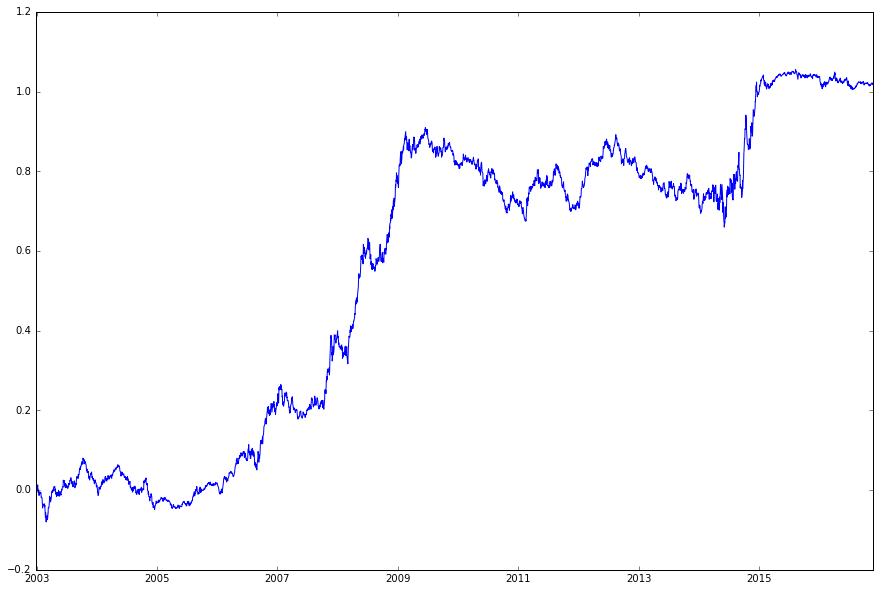

In [21]:
f=f.dropna(axis=0)
f['daily_return']=f['diff_return']*f['position']
f['strategy_cum_return']=f['daily_return'].cumsum()
plt.figure(figsize=(15,10))
plt.plot(f['strategy_cum_return'])

In [22]:
(np.mean(f['daily_return'])*252-0.03)/(np.std(f['daily_return'])*np.sqrt(252))

0.38992547348299056

In [23]:
position_lag=[np.nan]
position_lag.extend(f['position'][:-1])
f['position_lag']=position_lag

In [24]:
f['position']=f['position']-f['position_lag']
f['position']=f['position'].fillna(2.)
f['position']=f['position']/2
f['position']=f['position']*f['dir_strength']
f['position']=f['position'].apply(lambda x:np.nan if x==0 else x)

In [25]:
f['trade_num']=f['position'].apply(abs)
f['trade_num']=f['trade_num'].fillna(0)
f['trade_num']=f['trade_num'].cumsum()

In [26]:
f_all=pd.DataFrame()
for i,j in f.groupby('trade_num'):
    j=j.sort()
    j['trade_cum_return']=j['daily_return'].cumsum()
    j['trade_cum_max']=j['trade_cum_return'].cummax()
    j['cum_threshold']=j['trade_cum_max'].apply(lambda x: 0.75*x if x>=0.02 else -0.02)
    stop=[-0.02]
    stop.extend(j['cum_threshold'][:-1])
    j['cum_threshold']=stop
    j['compare']=j['trade_cum_return']-j['cum_threshold']
    j['daily_return']=j['daily_return']+np.abs(j['compare'].apply(lambda x: x if x<0 else 0))
    j['temp']=j['compare'].apply(lambda x: 0 if x<0 else np.nan)
    j['position']=j['position'].fillna(j['temp'])
    j['position']=j['position'].fillna(method='ffill')
    j['daily_return']=np.abs(j['position'])*j['daily_return']
    j['trade_cum_return']=j['daily_return'].cumsum()
    j['trade_cum_max']=j['trade_cum_return'].cummax()
    j['trade_drawdown']=j['trade_cum_max']-j['trade_cum_return']
    f_all=f_all.append(j)

In [27]:
f_all['strategy_cum_return_stoploss']=f_all['daily_return'].cumsum()

In [28]:
f_all

beta_return  dir_strength  dir_strength_threshold    SPGSCI  \
update_date                                                                
2002-12-26     -0.004139           1.0                0.225697 -0.000478   
2002-12-27      0.003618           1.0                0.225697  0.002957   
2002-12-30     -0.032873           1.0                0.225697 -0.029190   
2002-12-31     -0.007905           1.0                0.225697 -0.006744   
2003-01-02      0.032649           1.0                0.225697  0.023949   
2003-01-03      0.030080           1.0                0.225697  0.024716   
2003-01-06     -0.037238           1.0                0.225697 -0.025242   
2003-01-07     -0.016479           1.0                0.225697 -0.014256   
2003-01-08     -0.010288           1.0                0.225697 -0.005199   
2003-01-09      0.038542           1.0                0.225697  0.027112   
2003-01-10     -0.013692           1.0                0.225697 -0.013205   
2003-01-13      0.018043           1.0                0.225697  0.010837   
2003-01-14     -0.000497           1.0                0.225697  0.002016   
2003-01-15      0.022571           1.0                0.225697  0.015542   
2003-01-16      0.014087           1.0                0.225697  0.010201   
2003-01-17     -0.004877           1.0                0.225697 -0.000287   
2003-01-21     -0.002953           1.0                0.225697  0.001139   
2003-01-22      0.005544           1.0                0.225697  0.001404   
2003-01-23     -0.013530           1.0                0.225697 -0.010998   
2003-01-24      0.019686           1.0                0.225697  0.018470   
2003-01-27     -0.019471           1.0                0.225697 -0.018130   
2003-01-28      0.012176           1.0                0.225697  0.010415   
2003-01-29      0.035111           1.0                0.225697  0.024493   
2003-01-30      0.005143           1.0                0.225697  0.004856   
2003-01-31     -0.003884           1.0                0.225697 -0.002745   
2003-02-03     -0.006354           1.0                0.225697 -0.007915   
2003-02-04      0.022005           1.0                0.225697  0.015726   
2003-02-05      0.011135           1.0                0.225697  0.007238   
2003-02-06      0.013768           1.0                0.225697  0.008584   
2003-02-07      0.035233           1.0                0.225697  0.025059   
...                  ...           ...                     ...       ...   
2016-10-11     -0.010466           0.0                0.372056 -0.008656   
2016-10-12     -0.007656           0.0                0.370442 -0.009258   
2016-10-13      0.006332           0.0                0.370435  0.006653   
2016-10-14     -0.000686           0.0                0.369327 -0.000479   
2016-10-17     -0.003773           0.0                0.368922 -0.002687   
2016-10-18      0.003487           0.0                0.368504  0.002513   
2016-10-19      0.010889           0.0                0.367815  0.010412   
2016-10-20     -0.016210           0.0                0.367423 -0.014345   
2016-10-21      0.004113           0.0                0.366067  0.004525   
2016-10-24     -0.000921           0.0                0.364549 -0.002213   
2016-10-25     -0.002031           0.0                0.363817 -0.004917   
2016-10-26     -0.006627           0.0                0.361414 -0.007108   
2016-10-27      0.008125           0.0                0.356592  0.008786   
2016-10-28     -0.008193           0.0                0.355654 -0.010017   
2016-10-31     -0.022846           0.0                0.345526 -0.022938   
2016-11-01     -0.000718           0.0                0.342906 -0.002822   
2016-11-02     -0.018630           0.0                0.340607 -0.015938   
2016-11-03     -0.004433           0.0                0.339498 -0.007390   
2016-11-04     -0.011302           0.0                0.338942 -0.009097   
2016-11-07      0.008841           0.0                0.33813

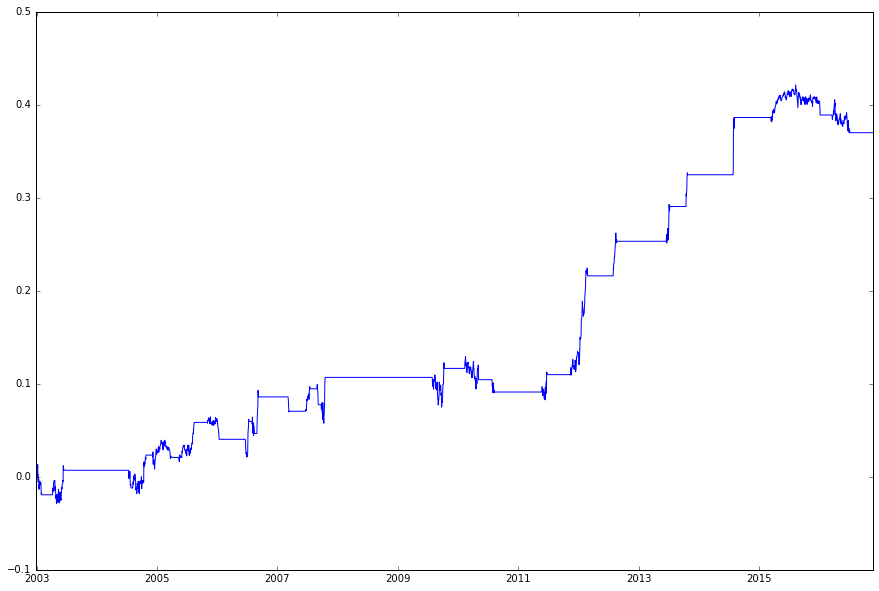

In [29]:
plt.figure(figsize=(15,10))
plt.plot(f_all['strategy_cum_return_stoploss'])

In [30]:
(np.mean(f_all['daily_return'])*252-0.03)/(np.std(f_all['daily_return'])*np.sqrt(252))

-0.085622400400095125

In [31]:
f_all['strategy_drawdown']=f_all['strategy_cum_return_stoploss'].cummax()-f_all['strategy_cum_return_stoploss']

In [32]:
f_all['strategy_drawdown'].max()

0.051288247635247364

In [33]:
f['cum_beta']=f['beta_return'].cumsum()
f['cum_gsci']=f['SPGSCI'].cumsum()

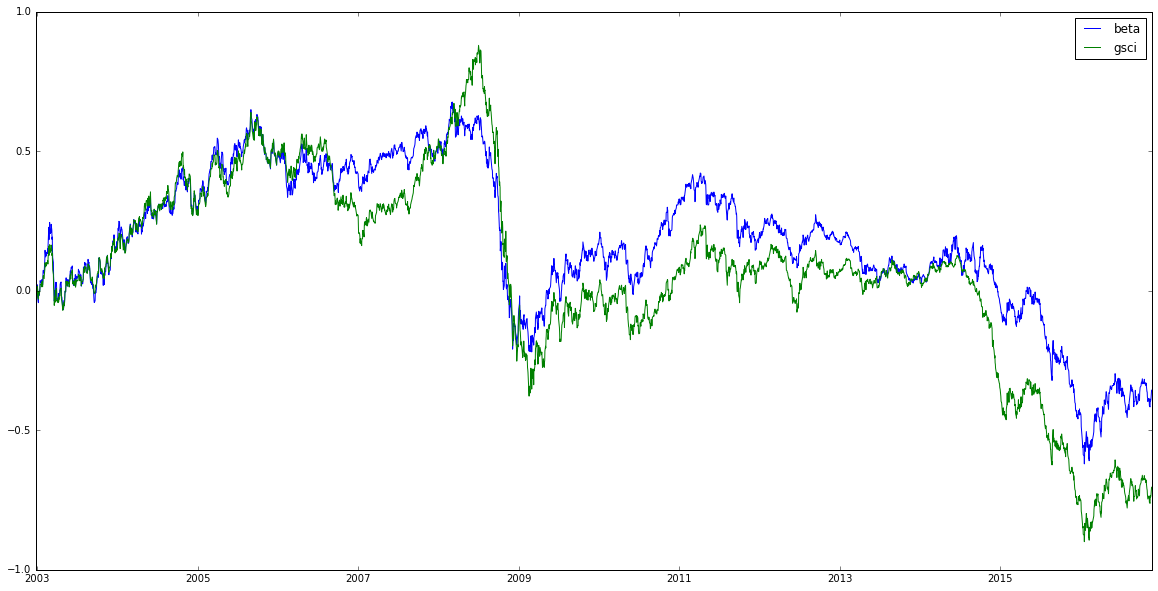

In [34]:
plt.figure(figsize=(20,10))
plt.plot(f['cum_beta'],label='beta')
plt.plot(f['cum_gsci'],label='gsci')
plt.legend()

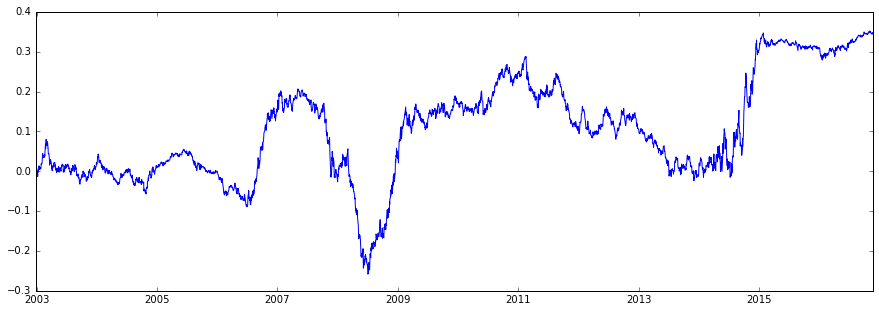

In [35]:
plt.figure(figsize=(15,5))
plt.plot(f['cum_beta']-f['cum_gsci'])

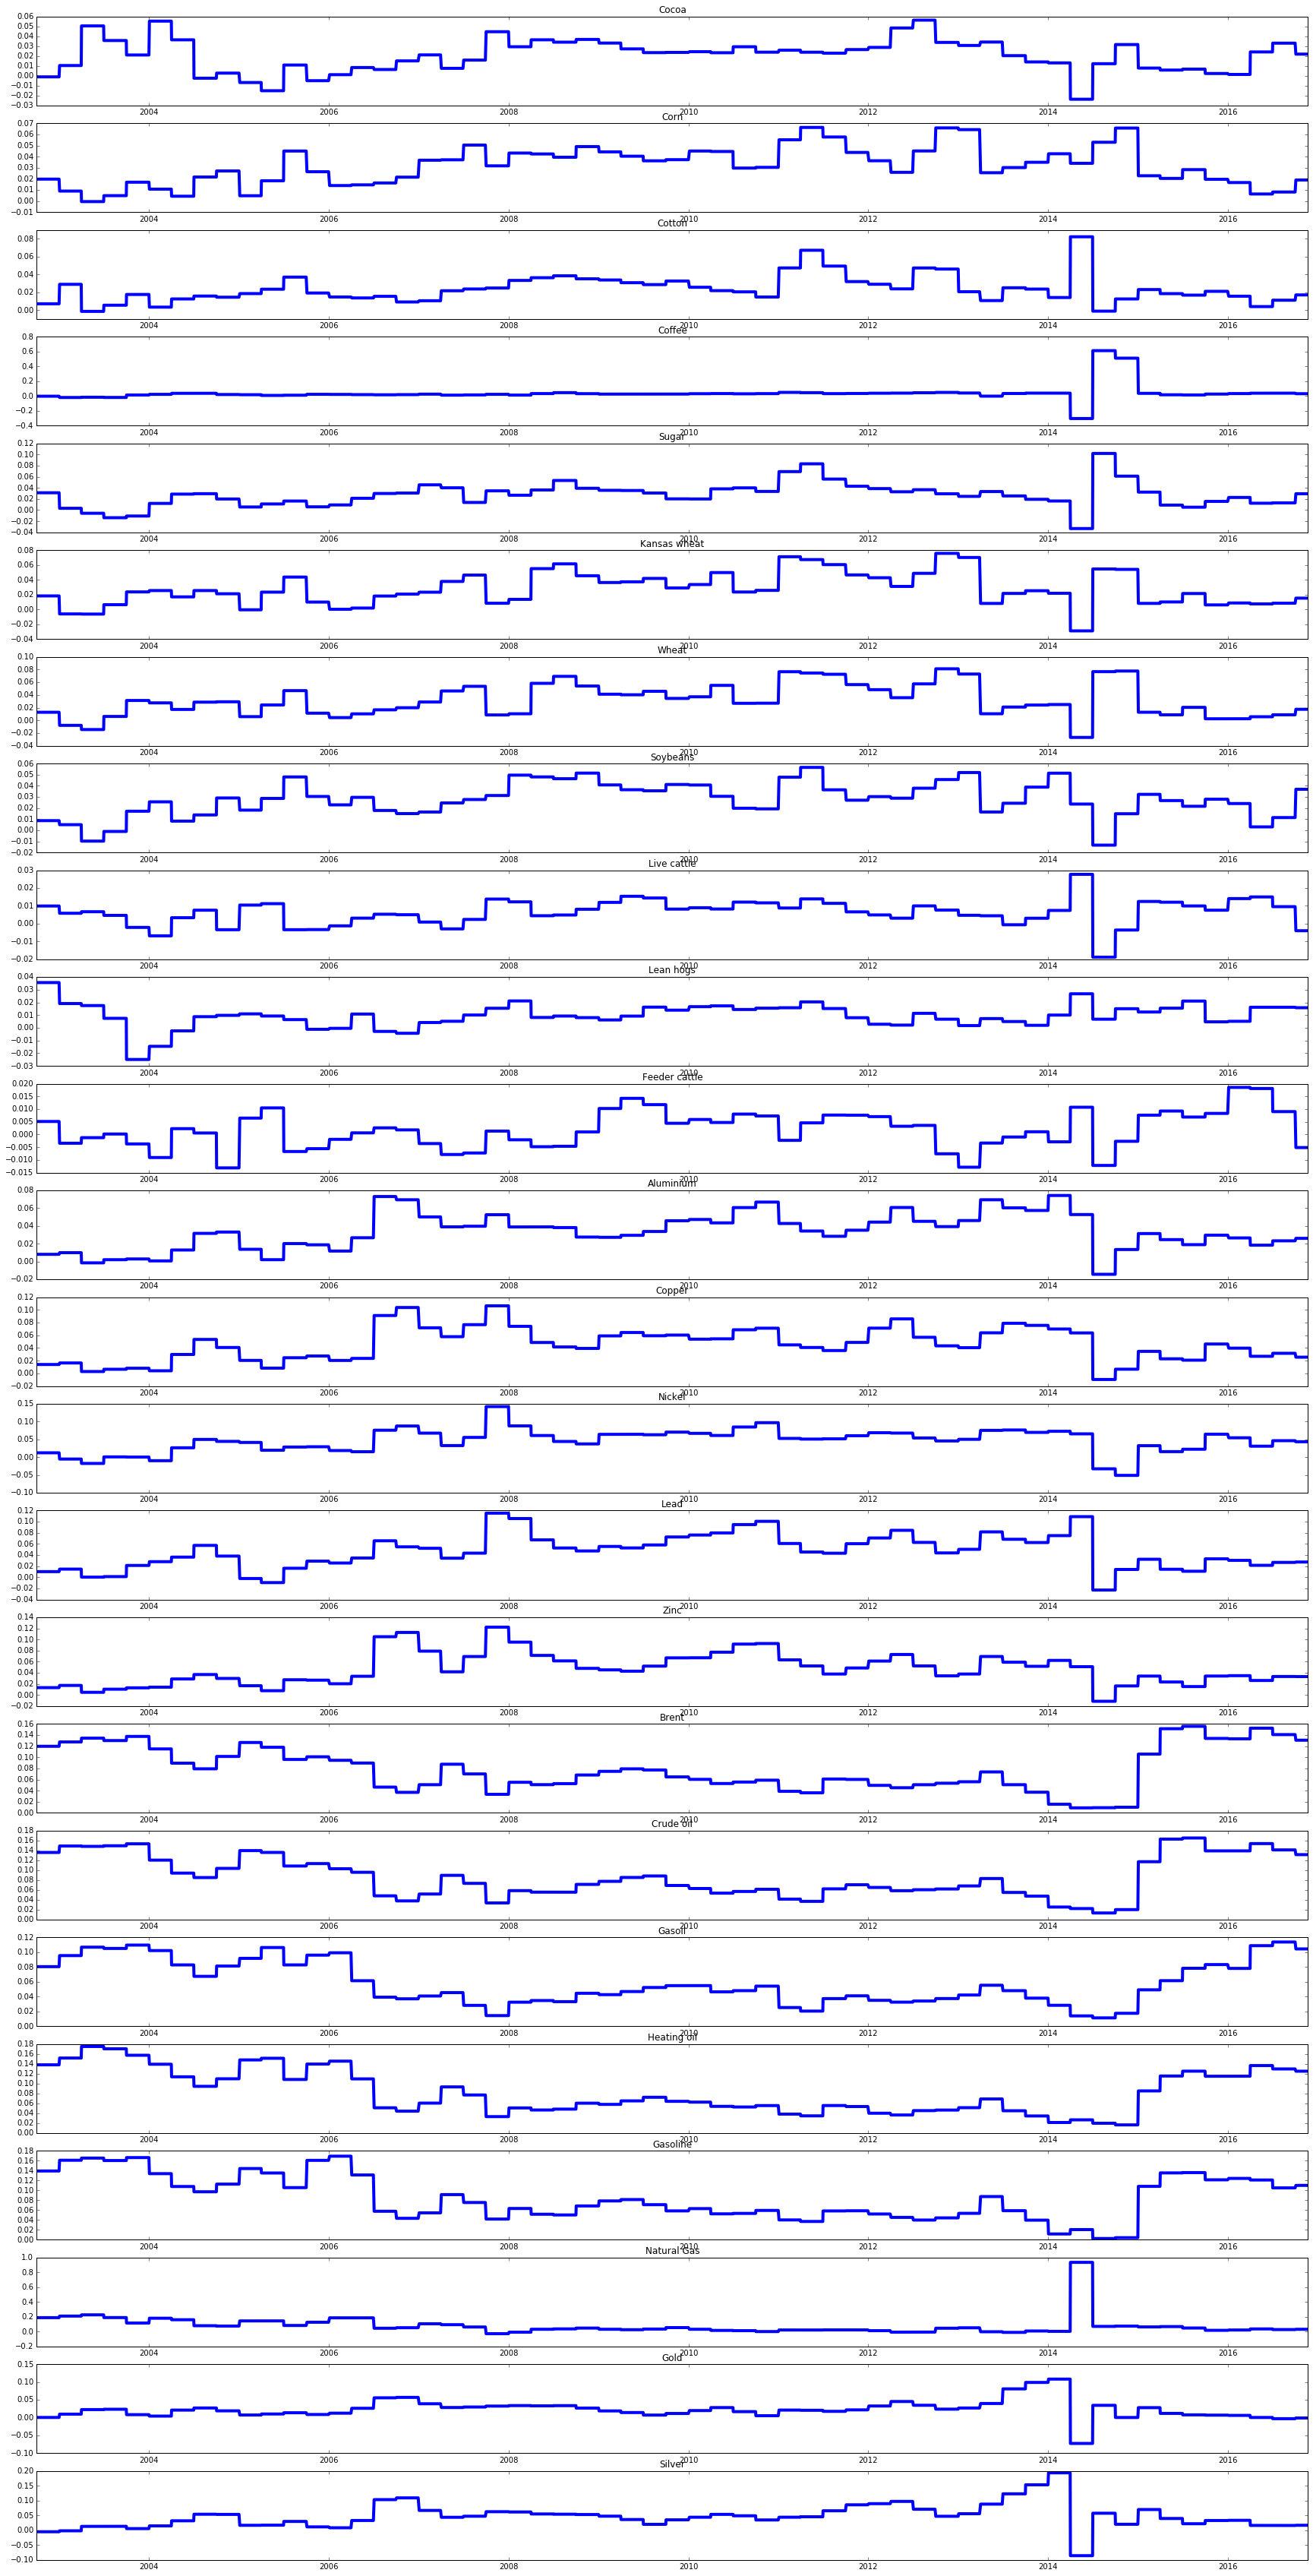

In [36]:
plt.figure(figsize=(30,60))
for i in range(len(all_w.columns)):

    plt.subplot(len(all_w.columns),1,i+1)
    plt.plot(all_w[all_w.columns[i]],label=ER_dict[all_w.columns[i]],lw=4)
    
    plt.title(ER_dict[all_w.columns[i]])
    plt.autoscale()
#     plt.legend()